In [ ]:
# ======================================================================================== #
#                           Project: Hotel Reservations
#                     
#                           Team: Nabil, Hafid, Meriem
# ======================================================================================== #



In [1]:

# ============================================================================ #
#                         Environment Path Configuration                       #
# ============================================================================ #
import sys
import os
env_path = os.path.dirname(sys.executable)
os.environ['PATH'] = f"{env_path}:{os.environ['PATH']}"

In [2]:
# ==================================================== #
#        Load Required Libraries
# ==================================================== #

import shutil
from datetime import datetime
import io

# Disable Metal API Validation
os.environ["METAL_DEVICE_WRAPPER_TYPE"] = "0" 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.activations import softmax

# Set styling for better visualization
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


%reload_ext watermark
%watermark -a "Nabil" -u -d -m    
print("*"*72)
print("Imported Packages and Their Versions:")
print("*"*72)
%watermark -iv

Author: Nabil

Last updated: 2025-01-24

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 142 Stepping 12, GenuineIntel
CPU cores   : 8
Architecture: 64bit

************************************************************************
Imported Packages and Their Versions:
************************************************************************
sys       : 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
matplotlib: 3.9.2
tensorflow: 2.18.0
numpy     : 2.0.2
keras     : 3.6.0
pandas    : 2.2.3
imblearn  : 0.13.0
seaborn   : 0.13.2
sklearn   : 1.5.2



In [3]:
try:
    import tensorboard
    print(f"TensorBoard version: {tensorboard.__version__}")
except ImportError as e:
    print(f"Error importing TensorBoard: {e}")

TensorBoard version: 2.18.0


In [4]:
os.getcwd()

'D:\\deep learning'

************************************************************************
               
extract the important info from the data                
************************************************************************
************************************************************************

check the shape of the dataset:(36275, 19)
************************************************************************
************************************************************************

check the first five rows of the dataset:  Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
0   INN00001             2               0                     1   
1   INN00002             2               0                     2   
2   INN00003             1               0                     2   
3   INN00004             2               0                     0   
4   INN00005             2               0                     1   

   no_of_week_nights type_of_meal_plan  required_car_parking_space 

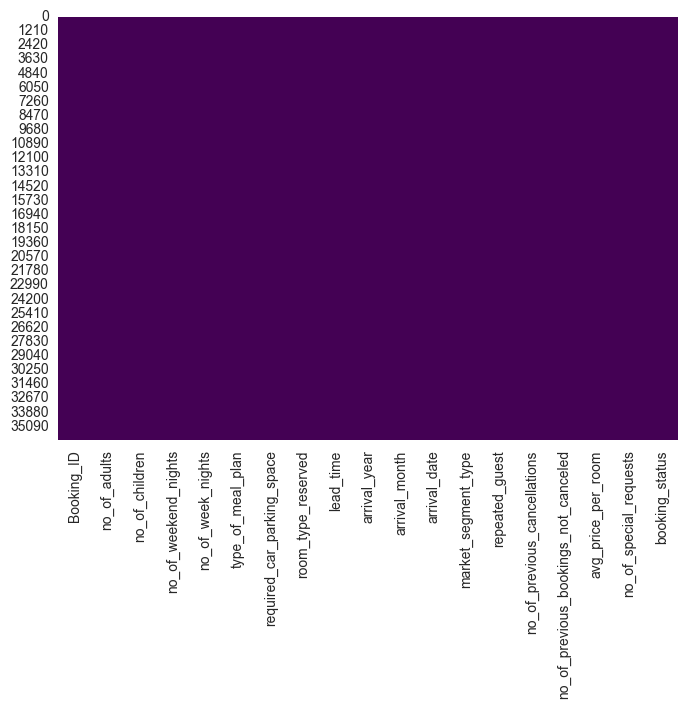

In [25]:
# Explore the data
url="https://raw.githubusercontent.com/DrNabil/data/refs/heads/main/Hotel%20Reservations.csv"
def load_and_explore_data(url):
    """
    download and explore the data
    """
    
    #download the data
    df=pd.read_csv(url, sep=',')
    

    print("*"*72)
    print("\nextract the important info from the data".center(72))
    print("*"*72)
    
    print("*"*72)
    print(F"\ncheck the shape of the dataset:{df.shape}")
    print("*"*72)
    
    print("*"*72)
    print(F"\ncheck the first five rows of the dataset:{df.head()}")
    print("*"*72)
    
    print("*"*72)
    print(F"\ncheck the last five rows of the dataset:{df.tail()}")
    print("*"*72)
    
    print("*"*72)
    print(F"\nthe info of the dataset: {df.info()}")
    
    print("*"*72)
    print(F"\nthe description of the dataset: {df.describe(include="all").T}")
    print("*"*72)
    
    print("*"*72)
    print(F"\nCheking the missing values: {df.isnull().sum()}")
    print("*"*72)
    
    print("*"*72)
    print(F"\nThe percent of missing values in each column:{(round(((df.isnull().sum()/len(df.index))*100),2).to_frame('null')).sort_values('null', ascending=False)}")

    print("plotting the missing values")
    print(F"\nteh plot of the missing values:{sns.heatmap(df.isna(), cbar=False, cmap="viridis")}")
    sns.heatmap(df.isna(), cbar=False, cmap="viridis")
    plt.show()

df=load_and_explore_data(url)

In [9]:
(df.select_dtypes(include=['object'])).columns

Index(['Booking_ID', 'type_of_meal_plan', 'room_type_reserved',
       'market_segment_type', 'booking_status'],
      dtype='object')

In [10]:
print(df['booking_status'].unique())
print(df['booking_status'].value_counts())

['Not_Canceled' 'Canceled']
booking_status
Not_Canceled    24390
Canceled        11885
Name: count, dtype: int64


In [11]:
df["booking_status"].describe()

count            36275
unique               2
top       Not_Canceled
freq             24390
Name: booking_status, dtype: object

In [12]:
print(df['booking_status'].value_counts()/df["booking_status"].count())

booking_status
Not_Canceled    0.672364
Canceled        0.327636
Name: count, dtype: float64


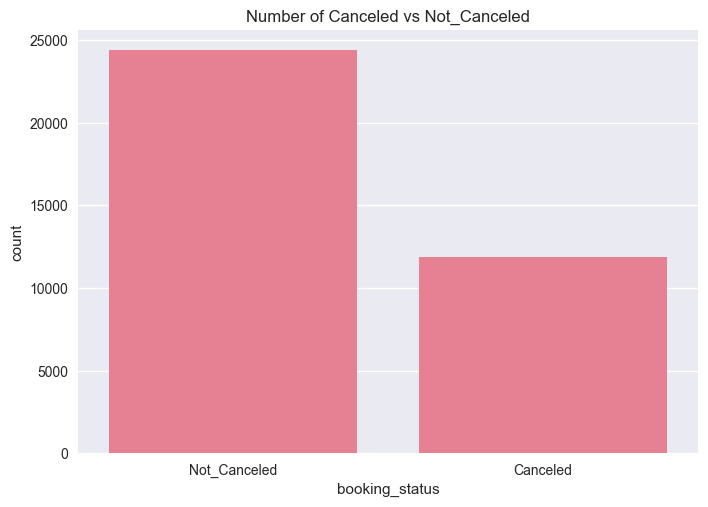

In [13]:
# Bar plot for the number of Canceled vs Not_Canceled reservation
sns.countplot(x='booking_status', data=df)
plt.title('Number of Canceled vs Not_Canceled')
plt.show()

In [14]:
def preprocessing_data():
    """
    Preprocessing the data to transform raw data into a clean structured format for analysis
    """
    data=df
    data=data.drop(['Booking_ID'], axis=1)
    y=data['booking_status']
    X=data.drop(['booking_status'], axis=1)
    X=pd.get_dummies(X, dtype=int)
    lb=LabelEncoder()
    y=lb.fit_transform(y)

    #oversampling the train dataset
    smtm=SMOTETomek(random_state=234)
    X, y=smtm.fit_resample(X, y)

    # Split data
    X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
     
    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

In [15]:
# Create the model
def create_model():
    """
    Create the model to be analyzed
    """
    X_train, X_test, y_train, y_test=preprocessing_data()
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        
        # Second layer
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        # Third layer
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        
        # Fourth layer
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.BatchNormalization(),

        
        # Output layer for binary classification
        tf.keras.layers.Dense(y_train.ndim, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer= optimizer, loss=tf.keras.losses.binary_crossentropy, metrics=[
        tf.keras.metrics.Accuracy(name="accuracy"),
        tf.keras.metrics.AUC(name="AUC")
    ])
    
    return model

In [16]:
# A function to train the model with adaptive lr.
def train_model_with_callbacks():
    """
    train the model
    """
    # Load and preprocess data
    X_train, X_test, y_train, y_test = preprocessing_data()
    model=create_model()
    # Create checkpoint directory
    checkpoint_dir = 'hotel_reservation'
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)


    # Define callbacks
    model_name='hotel_reservation'
    base_dir = "training_logs"
    log_dir = os.path.join(base_dir, "logs", model_name, datetime.now().strftime('%Y%m%d-%H%M%S'))
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)


    # TensorBoard callback
    tensorboard = tf.keras.callbacks.TensorBoard(
        log_dir=base_dir,
        histogram_freq=1,
        write_graph=True,
        write_images=False,
        update_freq='epoch',
        profile_batch=(5, 10)
    ) 
    
    # early_stopping callbacks 
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='AUC',  # Monitor AUC instead of loss
        mode='max',         # We want to maximize AUC
        patience=30,        
        min_delta=0.002,    
        restore_best_weights=True,
        verbose=1
    )

    # checkpoint callbacks 
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, 'best_model.keras'),
        monitor='AUC',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    # lr_reducer callbacks
    lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='AUC',
        factor=0.5,  # Reduce LR by half when plateauing
        patience=15,  # Wait for 10 epochs before reducing LR
        min_delta=0.0001,
        min_lr=1e-6,
        verbose=1
    )

    %timeit
    print("start trarining")
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=120,
        batch_size=32,
        validation_split=0.2,
        callbacks=[tensorboard, early_stopping, checkpoint, lr_reducer],
        verbose=1
    )
    
    return model, history, X_test, y_test

In [17]:
# Plotting function
def plot_training_curves(history):
    """
    Plot comprehensive training curves
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    # Plot AUC
    ax3.plot(history.history['AUC'], label='Training AUC')
    ax3.plot(history.history['val_AUC'], label='Validation AUC')
    ax3.set_title('Model AUC')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('AUC')
    ax3.legend()
    ax3.grid(True)
    
    # Plot early stopping point
    best_epoch = np.argmax(history.history['AUC'])
    epochs = range(1, len(history.history['loss']) + 1)
    ax4.plot(epochs, history.history['AUC'], 'b-', label='AUC')
    ax4.axvline(x=best_epoch + 1, color='r', linestyle='--', label='Early Stopping Point')
    ax4.set_title('Early Stopping Analysis')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('AUC')
    ax4.legend()
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()

In [18]:
def setup_tensorboard_with_figure_saving(model_name="test_tensorboard"):
    """
    Set up TensorBoard callback with figure saving capability
    """
    log_dir = os.path.join("logs", "fit", model_name, 
                          datetime.now().strftime('%Y%m%d-%H%M%S'))
    os.makedirs(log_dir, exist_ok=True)
    
    # Create file writer
    file_writer = tf.summary.create_file_writer(log_dir)
    
    # Function to save figures
    def plot_to_tensorboard(epoch, logs):
        with file_writer.as_default():
            # Create and save loss plot
            plt.figure(figsize=(10, 6))
            plt.plot(logs['loss'], label='Training Loss')
            plt.plot(logs['val_loss'], label='Validation Loss')
            plt.title('Model Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            
            # Convert plot to image
            buf = io.BytesIO()
            plt.savefig(buf, format='png')
            plt.close()
            
            # Write to TensorBoard
            image = tf.image.decode_png(buf.getvalue(), channels=4)
            image = tf.expand_dims(image, 0)
            tf.summary.image("Training Loss Plot", image, step=epoch)
    
    # Create TensorBoard callback
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,
        write_graph=True,
        write_images=True,
        update_freq='epoch',
        profile_batch=(5, 10)
    )
    
    # Create custom callback for saving plots
    plot_callback = tf.keras.callbacks.LambdaCallback(
        on_epoch_end=plot_to_tensorboard
    )
    
    return [tensorboard_callback, plot_callback]


In [19]:
def evaluate_model(model, X_test, y_test, history):
    """
    Comprehensive model evaluation
    """
    # Evaluate on test set
    test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test, verbose=0)
    
    # Get training statistics
    best_epoch = np.argmax(history.history['val_AUC']) + 1
    total_epochs = len(history.history['loss'])
    best_val_auc = max(history.history['val_AUC'])
    best_val_acc = max(history.history['val_accuracy'])
    
    print("\nModel Performance Summary:")
    print("-" * 50)
    print(f"Training stopped at epoch: {total_epochs}")
    print(f"Best performance at epoch: {best_epoch}")
    print(f"Best validation AUC: {best_val_auc:.4f}")
    print(f"Best validation accuracy: {best_val_acc:.4f}")
    print("\nTest Set Performance:")
    print(f"Test loss: {test_loss:.4f}")
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print("-" * 50)
    
    # Calculate early stopping effectiveness
    epochs_saved = 150 - total_epochs
    print(f"\nEarly Stopping saved {epochs_saved} epochs of training!")
    print(f"Training was automatically stopped at {total_epochs}/{150} epochs")

Converting targets to one-hot encoding...
Converting targets to one-hot encoding...
start trarining
Epoch 1/120
950/952 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7735 - accuracy: 0.0000e+00 - loss: 0.5733
Epoch 1: AUC improved from -inf to 0.84019, saving model to hotel_reservation\best_model.keras
952/952 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7737 - accuracy: 0.0000e+00 - loss: 0.5731 - val_AUC: 0.9097 - val_accuracy: 0.0000e+00 - val_loss: 0.3940 - learning_rate: 0.0010
Epoch 2/120
946/952 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8927 - accuracy: 0.0000e+00 - loss: 0.4134
Epoch 2: AUC improved from 0.84019 to 0.89413, saving model to hotel_reservation\best_model.keras
952/952 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8927 - accuracy: 0.0000e+00 - loss: 0.4134 - val_AUC: 0.9212 - val_accuracy: 0.0000e+00 - val_loss: 0.3726 - learning_rate: 0.0010
Epoch 3/120
944/952 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.9015 - accuracy: 0.0000e+00 - loss: 0.3961
Epoch 3: AUC improved from 0.8

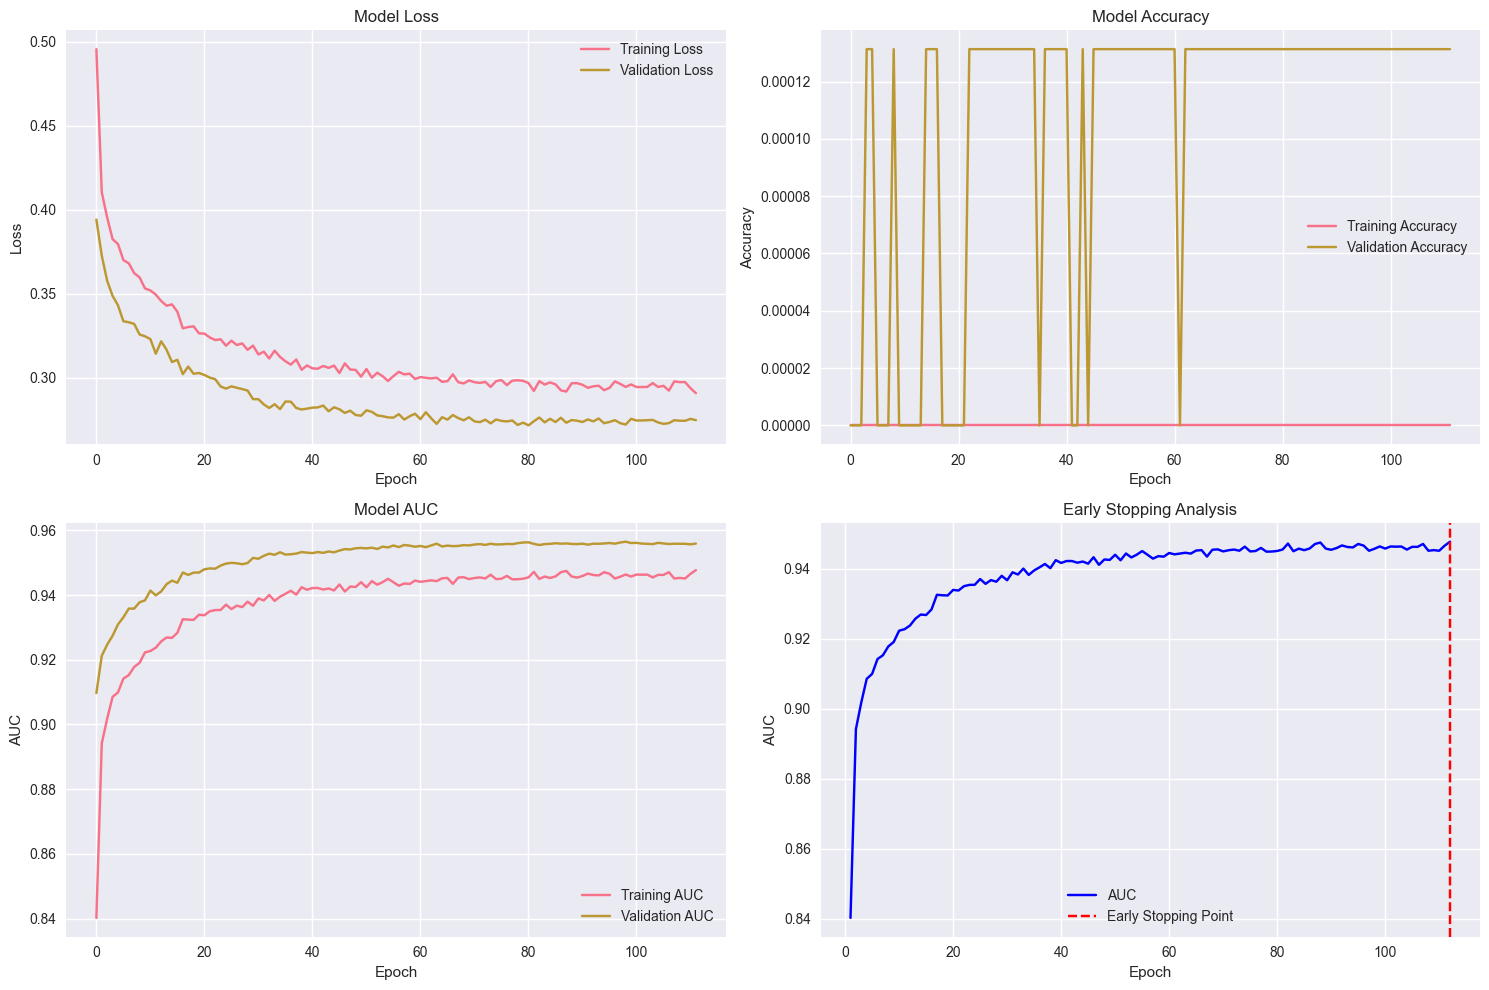


Model Performance Summary:
--------------------------------------------------
Training stopped at epoch: 112
Best performance at epoch: 99
Best validation AUC: 0.9565
Best validation accuracy: 0.0001

Test Set Performance:
Test loss: 0.2703
Test accuracy: 0.0000
Test AUC: 0.9565
--------------------------------------------------

Early Stopping saved 38 epochs of training!
Training was automatically stopped at 112/150 epochs


In [20]:
if __name__ == "__main__":
    # Train model
    model, history, X_test, y_test = train_model_with_callbacks()
    # Plot comprehensive results
    plot_training_curves(history)

    setup_tensorboard_with_figure_saving(model_name="test_tensorboard")
    # Evaluate and print results
    evaluate_model(model, X_test, y_test, history)

In [21]:
# # Clean up previous TensorBoard sessions
# %reload_ext tensorboard
# !rm -rf training_logs/logs/*

# # Create and train the model
# model = create_advanced_model()
# callbacks = create_callbacks()





In [27]:
# Launch TensorBoard
%reload_ext tensorboard
%tensorboard --logdir training_logs/logs

Reusing TensorBoard on port 6006 (pid 4392), started 1 day, 21:19:45 ago. (Use '!kill 4392' to kill it.)

In [28]:
from tensorboard.plugins.hparams import api as hp

In [29]:
def save_training_plots(history, save_dir="tensorboard_plots"):
    """
    Save training history plots to a specified directory
    """
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Get list of metrics from history
    metrics = [metric for metric in history.history.keys() 
              if not metric.startswith('val_')]
    
    # Plot each metric
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        
        # Plot training metric
        plt.plot(
            history.history[metric],
            label=f'Training {metric}'
        )
        
        # Plot validation metric if it exists
        if f'val_{metric}' in history.history:
            plt.plot(
                history.history[f'val_{metric}'],
                label=f'Validation {metric}'
            )
            
        plt.title(f'Model {metric}')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)
        
        # Save the plot
        plt.savefig(os.path.join(save_dir, f'{metric}_plot.png'))
        plt.close()
    
    print(f"Plots saved in directory: {save_dir}")

In [30]:
# Use in your training
callbacks = setup_tensorboard_with_figure_saving()
X_train, X_test, y_train, y_test = preprocessing_data()



# Create checkpoint directory
checkpoint_dir = 'hotel_reservation'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


# Define callbacks
model_name='hotel_reservation'
base_dir = "training_logs"
log_dir = os.path.join(base_dir, "logs", model_name, datetime.now().strftime('%Y%m%d-%H%M%S'))
if not os.path.exists(log_dir):
    os.makedirs(log_dir)


# TensorBoard callback
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir=base_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=False,
    update_freq='epoch',
    profile_batch=(5, 10)
) 
    
# early_stopping callbacks 
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='AUC',  # Monitor AUC instead of loss
    mode='max',         # We want to maximize AUC
    patience=30,        
    min_delta=0.002,    
    restore_best_weights=True,
    verbose=1
)

# checkpoint callbacks 
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best_model.keras'),
    monitor='AUC',
    mode='max',
    save_best_only=True,
    verbose=1
)

# lr_reducer callbacks
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='AUC',
    factor=0.5,  # Reduce LR by half when plateauing
    patience=15,  # Wait for 10 epochs before reducing LR
    min_delta=0.0001,
    min_lr=1e-6,
    verbose=1
)


history = model.fit(
    X_train, y_train,
    epochs=120,
    batch_size=32,
    validation_split=0.2,
    callbacks=[tensorboard, early_stopping, checkpoint, lr_reducer],
    verbose=2
)

# Use after model training
save_training_plots(history)

Converting targets to one-hot encoding...
Epoch 1/120

Epoch 1: AUC improved from -inf to 0.94467, saving model to hotel_reservation\best_model.keras
952/952 - 3s - 3ms/step - AUC: 0.9447 - accuracy: 0.0000e+00 - loss: 0.2987 - val_AUC: 0.9561 - val_accuracy: 1.3132e-04 - val_loss: 0.2729 - learning_rate: 7.8125e-06
Epoch 2/120

Epoch 2: AUC improved from 0.94467 to 0.94571, saving model to hotel_reservation\best_model.keras
952/952 - 3s - 3ms/step - AUC: 0.9457 - accuracy: 0.0000e+00 - loss: 0.2966 - val_AUC: 0.9556 - val_accuracy: 1.3132e-04 - val_loss: 0.2755 - learning_rate: 7.8125e-06
Epoch 3/120

Epoch 3: AUC improved from 0.94571 to 0.94626, saving model to hotel_reservation\best_model.keras
952/952 - 3s - 3ms/step - AUC: 0.9463 - accuracy: 0.0000e+00 - loss: 0.2950 - val_AUC: 0.9562 - val_accuracy: 1.3132e-04 - val_loss: 0.2725 - learning_rate: 7.8125e-06
Epoch 4/120

Epoch 4: AUC improved from 0.94626 to 0.94695, saving model to hotel_reservation\best_model.keras
952/952 - 3s 